![example](images/director_shot.jpeg)

# I'm Bored, Recommend an Enjoyable Movie!

**Authors:** Brent Smart
***

## Overview

For this project, I investigated the movie rating history at Webflix to provide movie recommendations for users. This investigation uses the ratings of 943 members. Webflix's ability to recommend new movies for its users depends on it's ability to accurately predict a customer's likelyhood of enjoying a movie. Hence, the primary goal of this investigation is to accurately predict a customer's movie rating. Another goal is to make recommendations for customers new to the company. I was able to build a models that predicts their rating with a margin of error of just 0.67.

## Business Problem

Webflix will be able to recommend movies for users using the rating history of 943 of its customers. Doing so will help Webflix individualize recommendations to customers and help customers determine the movie they should (or should not) watch next. By providing users with movies they would mostly likely enjoy, the company will potentially keep customers enrolled in the monthly movie program and recommend the platform to friends and family members. Hence, the questions used in this analysis are as follows:

Which movies does a particular user enjoy? 

Which movies would users most likely enjoy based on users with similar rating history (content-based filtering)?

## Data Understanding

This project uses the MovieLens data set GroupLens Research. The data set provides 100,000 ratings (1-5) from 943 users on 1682 movies. Each user has a unique user id, demographics, and rated at least 20 movies. Since the purpose of this project is to investigate the types of movies users enjoy to help make recommendations, the target variable is the user ratings. All features are included except for the movie release date. 

In [1]:
# conda install -c conda-forge scikit-surprise
# ! pip install pyspark
# ! pip3 install findspark
# ! pip install py4j

In [2]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import surprise
import random
import functions.data_preparation as dc

from surprise.prediction_algorithms import knns
from surprise.model_selection import cross_validate, train_test_split
from surprise import Reader, Dataset, SVD, accuracy, KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import train_test_split, cross_validate, GridSearchCV
from scipy.sparse import csr_matrix

my_seed = 0
random.seed(my_seed)
np.random.seed(my_seed)

%matplotlib inline

## Data Preparation

The data was prepared to include only users that rated at least 20 movies. There are no relevant missing values. When combining the different data sets (users, ratings and movie titles), a column with encoded genre reversed was created. The timestamp was converted into date and time format for an easier analysis.Some movies on included in the data set had 1 rating. Movies with less than 10 ratings were removed from this investigation.

In [3]:
# Cleaning data

pre_dataset = dc.full_clean()
users = pre_dataset[0]
ratings = pre_dataset[1]
basic_df = pre_dataset[2]
movies_df = pre_dataset[3]

In [4]:
users.head()

,userId,age,gender,occupation,zipCode
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [5]:
ratings.head()

,userId,movieId,rating,ratingCompleted
0,196,242,3,1997-12-04 10:55:49
1,186,302,3,1998-04-04 14:22:22
2,22,377,1,1997-11-07 02:18:36
3,244,51,2,1997-11-27 00:02:03
4,166,346,1,1998-02-02 00:33:16


In [6]:
basic_df.head()

,userId,age,gender,occupation,zipCode,movieId,rating,ratingCompleted
0,1,24,M,technician,85711,61,4,1997-11-03 02:33:40
1,1,24,M,technician,85711,189,3,1998-03-01 01:15:28
2,1,24,M,technician,85711,33,4,1997-11-03 02:38:19
3,1,24,M,technician,85711,160,4,1997-09-23 23:42:27
4,1,24,M,technician,85711,20,4,1998-02-13 23:51:23


In [7]:
movies_df.head()

,movieId,movieTitle,releaseDate,IMDbURL,unknown,Action,Adventure,Animation,Kids,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [8]:
movies_df['genre'] = ''
for col_name in movies_df.columns[5:-1]:
    movies_df.loc[movies_df[col_name]==1,'genre'] = movies_df['genre']+' '+col_name+'|'

In [9]:
movies_df

,movieId,movieTitle,releaseDate,IMDbURL,unknown,Action,Adventure,Animation,Kids,Comedy,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,genre
0,1,Toy Story (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,Animation| Kids| Comedy|
1,2,GoldenEye (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,1,0,0,Action| Adventure| Thriller|
2,3,Four Rooms (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,Thriller|
3,4,Get Shorty (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,Action| Comedy| Drama|
4,5,Copycat (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,Crime| Drama| Thriller|
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Drama|
1678,1679,B. Monkey (1998),06-Feb-1998,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,Romance| Thriller|
1679,1680,Sliding Doors (1998),01-Jan-1998,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,Drama| Romance|
1680,1681,You So Crazy (1994),01-Jan-1994,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,Comedy|


In [10]:
movies_df = movies_df.drop(movies_df.columns[2:-1], axis=1)
movies_df

,movieId,movieTitle,genre
0,1,Toy Story (1995),Animation| Kids| Comedy|
1,2,GoldenEye (1995),Action| Adventure| Thriller|
2,3,Four Rooms (1995),Thriller|
3,4,Get Shorty (1995),Action| Comedy| Drama|
4,5,Copycat (1995),Crime| Drama| Thriller|
...,...,...,...
1677,1678,Mat' i syn (1997),Drama|
1678,1679,B. Monkey (1998),Romance| Thriller|
1679,1680,Sliding Doors (1998),Drama| Romance|
1680,1681,You So Crazy (1994),Comedy|


In [11]:
data = dc.merge_datasets(basic_df, movies_df,'movieId')
data

,userId,age,gender,occupation,zipCode,movieId,rating,ratingCompleted,movieTitle,genre
0,1,24,M,technician,85711,61,4,1997-11-03 02:33:40,Three Colors: White (1994),Drama|
1,13,47,M,educator,29206,61,4,1997-12-14 18:02:32,Three Colors: White (1994),Drama|
2,18,35,F,other,37212,61,4,1997-11-21 11:46:43,Three Colors: White (1994),Drama|
3,58,27,M,programmer,52246,61,5,1998-01-08 19:21:11,Three Colors: White (1994),Drama|
4,59,49,M,educator,08403,61,4,1998-02-22 22:29:57,Three Colors: White (1994),Drama|
...,...,...,...,...,...,...,...,...,...,...
99995,863,17,M,student,60089,1679,3,1998-03-07 11:51:31,B. Monkey (1998),Romance| Thriller|
99996,863,17,M,student,60089,1678,1,1998-03-07 11:52:50,Mat' i syn (1997),Drama|
99997,863,17,M,student,60089,1680,2,1998-03-07 11:52:50,Sliding Doors (1998),Drama| Romance|
99998,896,28,M,writer,91505,1681,3,1998-02-10 20:32:02,You So Crazy (1994),Comedy|


In [12]:
num_votes = data.groupby('movieId')['rating'].agg('count')
num_votes

movieId
1       452
2       131
3        90
4       209
5        86
       ... 
1678      1
1679      1
1680      1
1681      1
1682      1
Name: rating, Length: 1682, dtype: int64

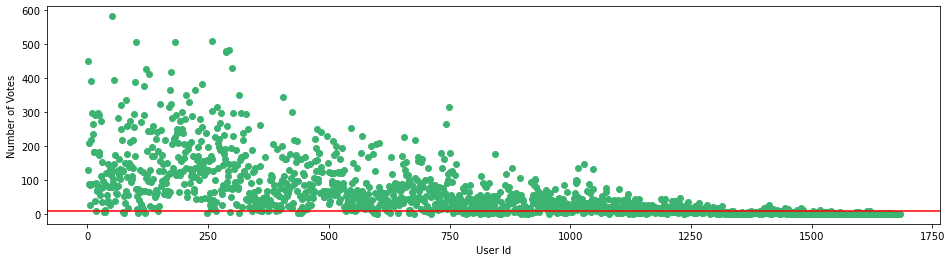

In [13]:
f,ax = plt.subplots(1,1,figsize=(16,4))
plt.scatter(num_votes.index,num_votes,color='mediumseagreen')
plt.axhline(y=10,color='r')
plt.xlabel('User Id')
plt.ylabel('Number of Votes')
plt.show()

In [14]:
# Dealing with outliers (movies with less than 10 ratings)
low_vote = data.groupby('movieId').filter(lambda x: len(x)<10)
print("Movies with low votes: ",low_vote)# grab after
df = data.groupby('movieId').filter(lambda x: len(x)>10)
df.set_index('movieId')

Movies with low votes:         userId  age gender     occupation zipCode  movieId  rating  \
1935        1   24      M     technician   85711      113       5   
1936       18   35      F          other   37212      113       5   
1937      257   17      M        student   77005      113       4   
1938      387   33      M  entertainment   37412      113       4   
1939      585   69      M      librarian   98501      113       3   
...       ...  ...    ...            ...     ...      ...     ...   
99995     863   17      M        student   60089     1679       3   
99996     863   17      M        student   60089     1678       1   
99997     863   17      M        student   60089     1680       2   
99998     896   28      M         writer   91505     1681       3   
99999     916   27      M       engineer   N2L5N     1682       3   

          ratingCompleted                                         movieTitle  \
1935  1997-11-03 02:38:58  Horseman on the Roof, The (Hussard sur l

,userId,age,gender,occupation,zipCode,rating,ratingCompleted,movieTitle,genre
movieId,,,,,,,,,
61,1,24,M,technician,85711,4,1997-11-03 02:33:40,Three Colors: White (1994),Drama|
61,13,47,M,educator,29206,4,1997-12-14 18:02:32,Three Colors: White (1994),Drama|
61,18,35,F,other,37212,4,1997-11-21 11:46:43,Three Colors: White (1994),Drama|
61,58,27,M,programmer,52246,5,1998-01-08 19:21:11,Three Colors: White (1994),Drama|
61,59,49,M,educator,08403,4,1998-02-22 22:29:57,Three Colors: White (1994),Drama|
...,...,...,...,...,...,...,...,...,...
1518,606,28,M,programmer,63044,4,1997-11-30 16:52:40,Losing Isaiah (1995),Drama|
1518,711,22,F,student,15203,3,1997-11-19 21:46:37,Losing Isaiah (1995),Drama|
1518,788,51,M,administrator,05779,3,1997-11-30 01:29:54,Losing Isaiah (1995),Drama|


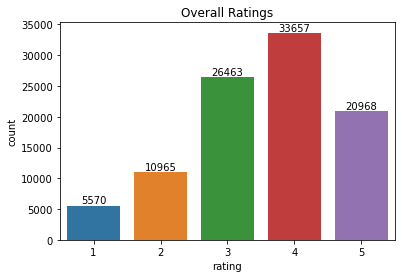

In [15]:
ax = sns.countplot(data=df, x=df['rating'])
ax.set_title('Overall Ratings')
ax.bar_label(ax.containers[0])
plt.show()

In [16]:
new_df = df[['userId','movieId','rating']]
new_df.head()

,userId,movieId,rating
0,1,61,4
1,13,61,4
2,18,61,4
3,58,61,5
4,59,61,4


In [17]:
#loaded full dataset
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(new_df, reader)
raw_ratings = data.raw_ratings

#shuffle ratings
random.shuffle(raw_ratings)

# A = 90% of data, B=10% of data
threshold = int(.9 * len(raw_ratings))
trainset_raw_ratings = raw_ratings[:threshold]
testset_raw_ratings = raw_ratings[threshold:]

In [18]:
data.raw_ratings = trainset_raw_ratings #data now trainset

In [19]:
# Grid search with SVD
params = {'n_factors': [20, 50, 100],
          'reg_all': [0.05, 0.02, 0.01],
          'n_epochs': [5, 10],
          'lr_all': [0.002, 0.005]}

gs_svd = GridSearchCV(SVD, param_grid=params, measures=['rmse'], cv=5)
gs_svd.fit(data)

In [20]:
gs_svd.best_params

{'rmse': {'n_factors': 20, 'reg_all': 0.01, 'n_epochs': 10, 'lr_all': 0.005}}

In [22]:
algo = gs_svd.best_estimator['rmse']

# retrain on entire training set
trainset = data.build_full_trainset()
algo.fit(trainset)

# Compute biased accuracy on train set
predictions = algo.test(trainset.build_testset())
print('Accuracy on Trainset: ', end='  ')
# Compute rmse
accuracy.rmse(predictions)

# Compute biased accuracy on test set
testset = data.construct_testset(testset_raw_ratings)
predictions = algo.test(testset)
print('Accuracy on Testset: ', end='  ')
# Compute rmse
accuracy.rmse(predictions)

Accuracy on Trainset:   RMSE: 0.8981
Accuracy on Testset:   RMSE: 0.9463


0.9462643473914761

The SVD has a RMSE of 0.898 on the testset. For a 1-5 scale, this is a large error. Further investigation into other algorithms is needed.

In [ ]:
# KNNBasic (user True)
sim_cos = {'name':'cosine', 'user_based':True}

basic = knns.KNNBasic(sim_options=sim_cos)
basic.fit(trainset)
basic.sim
predictions = basic.test(testset)
print(accuracy.rmse(predictions))

In [ ]:
# KNNBasic (User False)
sim_cos = {'name':'cosine', 'user_based':False}

basic = knns.KNNBasic(sim_options=sim_cos)
basic.fit(trainset)
basic.sim
predictions = basic.test(testset)
print(accuracy.rmse(predictions))

The KNN Basis with user_based: True has a RMSE of 0.9063, while the RSME with a user_based: False is 0.888. For a 1-5 scale, these are large errors and similar to the previous algorithm. Further investigation into other algorithms is needed.

In [ ]:
sim_pearson = {'name':'pearson', 'user_based':True}
basic_pearson = knns.KNNBasic(sim_options=sim_pearson)
basic_pearson.fit(trainset)
predictions = basic_pearson.test(testset)
print(accuracy.rmse(predictions))

In [ ]:
sim_pearson = {'name':'pearson', 'user_based':False}
basic_pearson = knns.KNNBasic(sim_options=sim_pearson)
basic_pearson.fit(trainset)
predictions = basic_pearson.test(testset)
print(accuracy.rmse(predictions))

The Pearson Correlation has performed best so far with a RMSE of 0.793 for True user_based and 0.797 for a False user_based. Because of the 1-5 rating scale, further investigations will be completed.

In [ ]:
sim_pearson = {'name':'pearson', 'user_based':True}
knn_means = knns.KNNWithMeans(sim_options=sim_pearson)
knn_means.fit(trainset)
predictions = knn_means.test(testset)
print(accuracy.rmse(predictions))

In [25]:
sim_pearson = {'name':'pearson', 'user_based':False}
knn_means = knns.KNNWithMeans(sim_options=sim_pearson)
knn_means.fit(trainset)
predictions = knn_means.test(testset)
print(accuracy.rmse(predictions))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9283
0.9283390737333677


The KNN with Means models takes into account the mean rating of each user and appears to performs best with a RSME of 0.679 and user_based = False. A final investigation will be completed before deciding.

In [ ]:
sim_pearson = {'name':'pearson', 'user_based':True}
knn_baseline = knns.KNNBaseline(sim_options=sim_pearson)
knn_baseline.fit(trainset)
predictions = knn_baseline.test(testset)
print(accuracy.rmse(predictions))

In [ ]:
sim_pearson = {'name':'pearson', 'user_based':False}
knn_baseline = knns.KNNBaseline(sim_options=sim_pearson)
knn_baseline.fit(trainset)
predictions = knn_baseline.test(testset)
print(accuracy.rmse(predictions))

This model does not perform as well as the previous model with with the lowest RSME of 0.683 with user_based set to False. KNNWithMeans will be the algorithm of choice. 

The KNN with Means models takes into account the mean rating of each user and appears to perform. Hence, it will used to make predictions.

# Making Movie Recommendations! (Modeling)

In [23]:
df_pivot = df.pivot(index='movieId',columns='userId',values='rating')
df_pivot.fillna(0, inplace=True)
df_pivot

userId,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
movieId,,,,,,,,,,,,,,,,,,,,,
1,5.0,4.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,4.0,...,2.0,3.0,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0
2,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,...,5.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
5,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1480,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
data = Dataset.load_from_df(new_df, reader)
dataset = data.build_full_trainset()

knn_means.fit(dataset)
knn_means.predict(2,1)


Computing the pearson similarity matrix...
Done computing similarity matrix.


Prediction(uid=2, iid=1, r_ui=None, est=4.050343276392038, details={'actual_k': 40, 'was_impossible': False})

In [29]:
def movie_rater(movie_df,num, genre=None):
    userID = 2000 
    rating_list = []
    while num > 0:
        if genre:
            movie = movie_df[movie_df['genre'].str.contains(genre)].sample(1)
        else:
            movie = movie_df.sample(1)
        print(movie)
        rating = input('How do you rate this movie on a scale of 1-5, press n if you have not seen :\n')
        if rating == 'n':
            continue
        else:
            rating_one_movie = {'userId':userID,'movieId':movie['movieId'].values[0],'rating':rating}
            rating_list.append(rating_one_movie) 
            num -= 1
    return rating_list 
user_rating = movie_rater(movies_df, 5, 'Comedy')


     movieId                movieTitle              genre
708      709  Strictly Ballroom (1992)   Comedy| Romance|
How do you rate this movie on a scale of 1-5, press n if you have not seen :
n
     movieId       movieTitle     genre
406      407  Spy Hard (1996)   Comedy|
How do you rate this movie on a scale of 1-5, press n if you have not seen :
3
      movieId      movieTitle     genre
1488     1489  Chasers (1994)   Comedy|
How do you rate this movie on a scale of 1-5, press n if you have not seen :
2
     movieId                                         movieTitle  \
255      256  When the Cats Away (Chacun cherche son chat) (...   

                 genre  
255   Comedy| Romance|  
How do you rate this movie on a scale of 1-5, press n if you have not seen :
3
      movieId             movieTitle                    genre
1443     1444  That Darn Cat! (1965)   Kids| Comedy| Mystery|
How do you rate this movie on a scale of 1-5, press n if you have not seen :
1
      movieId       

In [30]:
new_ratings_df = new_df.append(user_rating)
new_data = Dataset.load_from_df(new_ratings_df, reader)

In [31]:
#train model using new combined DataFrame

sim_pearson = {'name':'pearson', 'user_based':False}
knn_means_ = knns.KNNWithMeans(sim_options=sim_pearson)
knn_means_.fit(new_data.build_full_trainset())


Computing the pearson similarity matrix...
Done computing similarity matrix.


In [32]:
#making new user predictions

movie_list = []
for m_id in new_df['movieId'].unique():
    movie_list.append((m_id, knn_means_.predict(2000,m_id)[3]))
ranked_movies = sorted(movie_list, key=lambda x:x[1], reverse=True)

new_user_recs = pd.DataFrame(ranked_movies, columns=['movieId','predictedRating'])
new_user_recs_df = dc.merge_datasets(movies_df,new_user_recs,'movieId')
new_user_recs_df.sort_values('predictedRating',ascending=False).head(10)

,movieId,movieTitle,genre,predictedRating
586,615,"39 Steps, The (1935)",Thriller|,4.528120
924,1019,"Die xue shuang xiong (Killer, The) (1989)",Action| Thriller|,4.445015
412,429,"Day the Earth Stood Still, The (1951)",Drama| Sci-Fi|,4.415417
1009,1131,Safe (1995),Thriller|,4.393382
303,317,In the Name of the Father (1993),Drama|,4.389037
491,513,"Third Man, The (1949)",Mystery| Thriller|,4.307264
89,95,Aladdin (1992),Animation| Kids| Comedy| Musical|,4.290058
780,836,Ninotchka (1939),Comedy| Romance|,4.246503
391,408,"Close Shave, A (1995)",Animation| Comedy| Thriller|,4.237362
604,634,Microcosmos: Le peuple de l'herbe (1996),Documentary|,4.227273


## Evaluation
The model underwent multiple interactions, each time investigating how well the model was able to predict a user's rating. At the end, the final model showed an overall improvement in accurate predictions.

## Conclusion & Recommendations
The model works well for users with more data points. Recommendation: encourage users to rate frequently and honestly. 